In [3]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
import anndata
import scanpy as sc
import re
import decoupler as dc
import sc_toolbox
import random
import seaborn.objects as so

In [4]:
data_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/data/"
newdata_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/data/"
plot_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/new_out/final_plots/"

sys.path = sys.path + ["/well/immune-rep/users/vbw431/python_utils/"]

In [5]:
import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging
import rpy2.robjects.lib.ggplot2 as gp
from rpy2.robjects import pandas2ri
from rpy2.robjects import r
from rpy2.ipython.ggplot import image_png

#sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [6]:
%%R
.libPaths(c(paste0("/well/immune-rep/users/vbw431/conda/ivybridge/envs/scverse_new/r_modules"), .libPaths()))

library(tidyverse)
library(Seurat)


cur.dir = "/well/immune-rep/users/vbw431/Projects/Peppa/data/DIMITRA_FASTQ/"
work.dir = "/well/immune-rep/users/vbw431/Projects/Peppa/"
out.dir = "/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/out/"
references = "/well/immune-rep/users/vbw431/reference/reference/refdata-gex-GRCh38-2020-A/"
com.out = "/well/immune-rep/users/vbw431/Projects/Peppa/reference_combat/"

##plotting
library(ggplot2); theme_set(theme_bw(base_size = 18)+
                              theme(strip.text = element_text(colour = 'black', face="bold",size=12), 
                                    panel.grid.major = element_blank(), 
                                    panel.grid.minor = element_blank(),
                                    panel.border = element_rect(size = 0.7),
                                    axis.ticks.length=unit(.10, "cm"),
                                    axis.ticks = element_line(size=0.7),
                                    strip.background = element_blank()))



## Load Seurat data and Prepare for DGE

In [7]:
%%R 

##load, normalise  and trim to remove pre_treatment replicates and post vaccine samples from azimuth

peppa <- readRDS(paste0(out.dir, "/peppa_pbmc_all.rds"))




In [8]:
%%R 
unique(peppa@meta.data$celltype_consensus.l2)

 [1] "NK.Adaptive.CCL4.CCL3" "NK.Adaptive"           "NK.Mature"            
 [4] "NK.CD56bright"         "NK.Prolifering"        "CD8.TEMRA"            
 [7] "MPECs"                 "gdT"                   "MAIT"                 
[10] "CD8.Naive"             "CD8.TEM"               "CD8.TCM"              
[13] "CD4.Naive"             "CD4.TCM"               "CD4.TEMRA"            
[16] "CD4.TEM"               "CD4.Treg"              "CD4.Mitohi"           
[19] "dnT"                   "B.Naive"               "B.UNSW.Memory"        
[22] "B.CSW.Memory"          "B.DN.ITGAX"            "B.Plasmablast"        
[25] "cMono"                 "ncMono"                "pDC"                  
[28] "cDC2"                  "HSPC"                  "ASDC"                 
[31] "cDC1"                 


In [9]:
%%R
NK <- subset(peppa, subset = celltype_consensus.l1 == "NK")


In [10]:
%%R 
##filter pre vaccination samples and pre treatment samples out
NK <- subset(NK, subset = Treatment_status != "Pre_treatment")

trim_barcodes <- NK@meta.data %>% 
  dplyr::select(orig.ident) %>%
  dplyr::filter(grepl("_0|SeuratProject", orig.ident))
table(trim_barcodes)

NK <- subset(NK, cells = rownames(trim_barcodes))



In [11]:
##load data
adata = sc.read_h5ad("/well/immune-rep/users/vbw431/Projects/Peppa/out/peppa_azi_combat.h5ad")

labels = ["NK", "CD8", "CD4", "Bcells", "Myeloid_Plt"]
cluster_list = {}
scvi_list = {}
umap_list = {}
for i in [0,1,2,3,4]:
    print("reading in " + labels[i])
    cluster_list[labels[i]] = pd.read_csv(os.path.join(newdata_dir + labels[i] +"_clustering_final/", f"Peppa_{labels[i]}_cluster_assignment.csv"), index_col =0)
    scvi_list[labels[i]] = pd.read_csv(os.path.join(newdata_dir + labels[i] +"_embeddings/", f"Peppa_{labels[i]}_scvi.csv"), index_col =0)
    umap_list[labels[i]] = pd.read_csv(os.path.join(newdata_dir + labels[i] +"_embeddings/", f"Peppa_{labels[i]}_umap.csv"), index_col =0)

##generate adata_list
adata_list = {}

for i in [0,1,2,3, 4]:
    adata_list[labels[i]] = adata[cluster_list[labels[i]].index].copy()
    adata_list[labels[i]].obsm["X_scVI"] = scvi_list[labels[i]].loc[adata_list[labels[i]].obs_names].values
    adata_list[labels[i]].obsm["X_umap"] = umap_list[labels[i]].loc[adata_list[labels[i]].obs_names].values
    adata_list[labels[i]].obs = adata_list[labels[i]].obs.merge(cluster_list[labels[i]], left_index=True, right_index=True, how="inner")
    adata_list[labels[i]].layers['counts'] = adata_list[labels[i]].X.copy()
    sc.pp.normalize_total(adata_list[labels[i]], target_sum=1e4)
    sc.pp.log1p(adata_list[labels[i]])
    adata_list[labels[i]].layers['normalized'] = adata_list[labels[i]].X.copy()
    
##update meta_data with new clinical
clin_meta = pd.read_csv(newdata_dir + "index_demo.csv", index_col = 0)
clin_meta = clin_meta[["disease_group", 
                       "bio_replicate", 
                       "study_disease", 
                       "scanpy_index", 
                       "study_ID", 
                       "Treatment_status",
                      "Ethnicity",
                      "Sex",
                      "Age",
                      "HBV_serostatus",
                      "HBV_sAg_titre",
                      "HBV_DNA_VL"]]

new_obs = {}

for name in labels:
    del adata_list[name].obs["disease_group"]
    adata_list[name].obs["study_disease_orig"] = adata_list[name].obs["study_disease"].copy()
    del adata_list[name].obs["study_disease"]
    new_df = pd.merge(adata_list[name].obs, clin_meta, how='left', left_on = ['bio_replicate','scanpy_index'], right_on = ['bio_replicate','scanpy_index'])
    new_df.index = adata_list[name].obs.index
    new_obs[name] = new_df.copy()
    adata_list[name].obs = new_df.copy()

                 
for name in labels:
    adata_list[name].obs["celltype_consensus"] = str(name)

for name in labels:
    adata_list[name].obs["celltype_consensus.l1"] = str(name)
    adata_list[name].obs["celltype_consensus.l2"] = adata_list[name].obs[str(name+".annotation.l1")]
    adata_list[name].obs["celltype_consensus.l3"] = adata_list[name].obs[str(name+".annotation.l2")]
    
##concat
adata_all = anndata.concat(adata_list, join= "outer", index_unique=None)

##Assign CMV status based on azimuth preprint (https://doi.org/10.1016/j.cell.2021.04.048)

conditions = [
  ([re.search("_0|SeuratProject",a) is not None for a in adata_all.obs["orig.ident"]]),
  ([re.search("_0|SeuratProject",a) is None for a in adata_all.obs["orig.ident"]]),
 ]

# create a list of the values we want to assign for each condition
values = ["Subset", "Remove"]

# create a new column and use np.select to assign values to it using our lists as arguments
adata_all.obs["prevax"] = np.select(conditions, values)
adata_all = adata_all[adata_all.obs["prevax"] == "Subset"].copy()

NK = adata_all[adata_all.obs["celltype_consensus.l1"] == "NK"].copy()

reading in NK
reading in CD8
reading in CD4
reading in Bcells
reading in Myeloid_Plt


In [62]:
adata_all.obs["study_disease"].value_counts()

HBV        86895
CTRL       61449
HBV_HIV    43315
Name: study_disease, dtype: int64

In [19]:
NK_umap = pd.DataFrame(NK.obsm["X_umap"], index=NK.obs_names)

In [13]:
%%R -i NK_umap
NK_umap = as.data.frame(NK_umap)
colnames(NK_umap) = c("UMAP_1", "UMAP_2")

NK_umap <- NK_umap[rownames(NK_umap) %in% colnames(NK),]


In [14]:
##extract var features used for scvi integration
adata = sc.read_h5ad("/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/data/Peppa_azimuth_SCVI.h5ad")
adata.var_names


Index(['A2M', 'A2ML1', 'ABCA1', 'ABCA13', 'ABCA9-AS1', 'ABCB9', 'ABCG5',
       'ABI3', 'ABRA', 'AC000065.1',
       ...
       'ZNF683', 'ZNF695', 'ZNF703', 'ZNF84-DT', 'ZNF99', 'ZP3', 'ZPBP2',
       'ZSCAN1', 'ZSWIM2', 'ZWINT'],
      dtype='object', length=3000)

In [15]:
hvg = adata.var_names

In [16]:
%%R -i hvg
head(hvg)

[1] "A2M"       "A2ML1"     "ABCA1"     "ABCA13"    "ABCA9-AS1" "ABCB9"    


In [43]:
%%R
# Save the objects as separate matrices for input in slingshot
NK <- NormalizeData(NK)
#dimred <- NK@reductions$umap@cell.embeddings
dimred <- NK_umap

clustering <- NK$celltype_consensus.l2
group <- NK$study_disease

counts <- as.matrix(NK@assays$RNA@counts[hvg, ])

In [21]:
%%R
suppressPackageStartupMessages({
    library(slingshot)
})



class: PseudotimeOrdering 
dim: 17163 2 
metadata(3): lineages mst slingParams
pathStats(2): pseudotime weights
cellnames(17163): AAACCTGTCGCATGGC-1-HIVHBV_C
  AAACGGGAGATATACG-1-HIVHBV_C ... E2L8_TTTCACAAGAGAATCT
  E2L8_TTTCAGTTCTCAGAAC
cellData names(2): reducedDim clusterLabels
pathnames(2): Lineage1 Lineage2
pathData names(0):


In [35]:
%%R
# Run default Slingshot lineage identification
set.seed(1)

sds <- slingshot(dimred, clustering, start.clus ="NK.CD56bright", end.clus = c("NK.Adaptive.CCL4.CCL3", "NK.Mature", "NK.Adaptive", "NK.Prolifering"))
curves <- slingCurves(sds, as.df = TRUE)


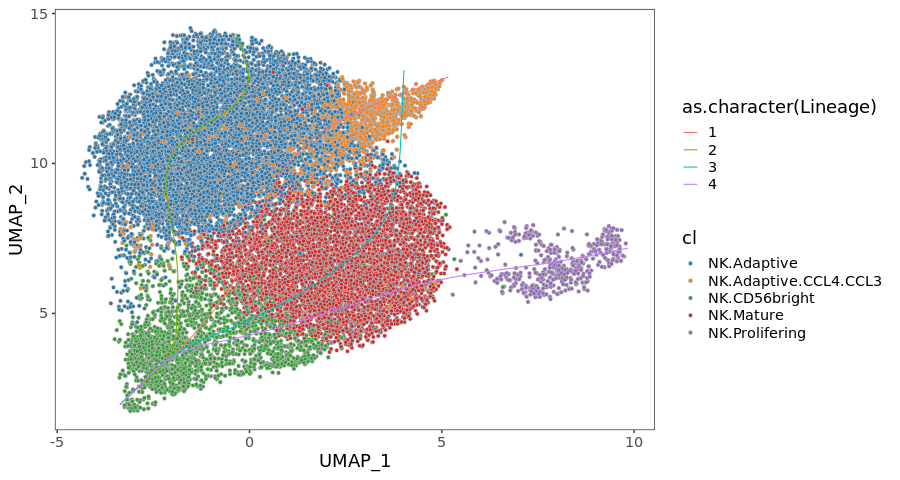

In [40]:
%%R -w 900

toplot <- data.frame(dimred, "cl" = as.character(clustering))

ggplot(toplot, aes(UMAP_1, UMAP_2)) +
  geom_point(aes(fill = cl), col = "grey70", shape = 21) + 
geom_path(data = curves %>% arrange(Order),
              aes(group = Lineage, color = as.character(Lineage))) +
ggsci::scale_fill_d3()
 

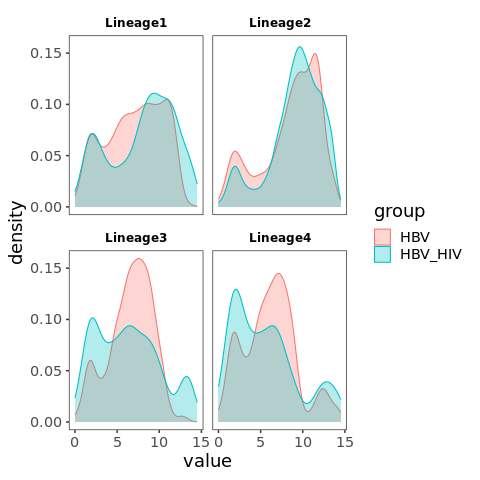

In [56]:
%%R
toplot <- data.frame(dimred, "cl" = as.character(clustering), "group" = group, slingPseudotime(sds))
head(toplot)
toplot %>% 
filter(group != "CTRL") %>%
reshape2::melt(id.vars = c("UMAP_1", "UMAP_2", "cl", "group")) %>% 
ggplot(aes(value, fill = group, color = group))+
geom_density(alpha=0.3)+
facet_wrap(~variable)


In [54]:
%%R
head(toplot[toplot$group == "HBV", "Lineage1"])

[1]       NA       NA 7.419777       NA       NA       NA


In [60]:
%%R
ks.test(toplot[toplot$group == "HBV", "Lineage1"],
        toplot[toplot$group == "HBV_HIV", "Lineage1"])


	Asymptotic two-sample Kolmogorov-Smirnov test

data:  toplot[toplot$group == "HBV", "Lineage1"] and toplot[toplot$group == "HBV_HIV", "Lineage1"]
D = 0.14168, p-value = 8.771e-15
alternative hypothesis: two-sided

